In [62]:
import nilearn
from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img
from nilearn.image import index_img

import numpy as np
import pandas as pd

## Averiguação da shape do dataset e importação do mesmo

In [63]:
fmri_img='C:\\Users\\Asus\\Documents\\3oAno\\Estágio\\\Dados\\sub-0001\\ses-001\\run-01\\sub-0001_ses-001_task-innerspeech_run-01_bold_pp_standard.nii'
dataset_shape=(image.load_img(fmri_img).shape)

print(dataset_shape)
dataset_shape[3]

(91, 109, 91, 258)


258

## Eventos

In [64]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2  # repetition time is ? second
n_scans = dataset_shape[3]  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH='C:\\Users\\Asus\\Documents\\3oAno\\Estágio\\Dados\\sub-0001_ses-001_task-innerspeech_run-01_events.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")


## Criação da tabela design_matrix (por fases e não betas)

In [65]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

<AxesSubplot:label='conditions', ylabel='scan number'>

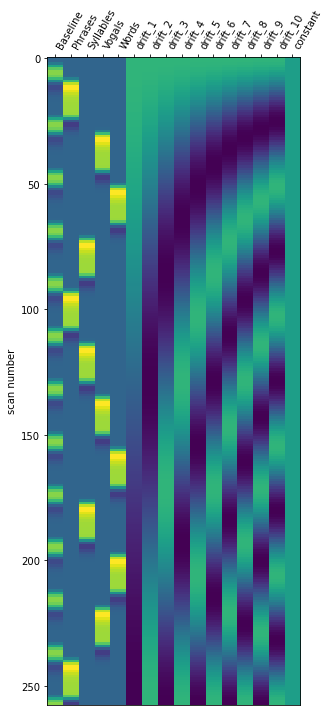

In [86]:
from nilearn.glm.first_level import FirstLevelModel

first_level_model = FirstLevelModel(tr)
first_level_model = first_level_model.fit(fmri_img, events=events_df)
design_matrix = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix)

In [67]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])
basic_contrasts

{'Baseline': array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Phrases': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Syllables': array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Vogals': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Words': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_1': array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_2': array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_3': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_4': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]),
 'drift_5': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
 'drift_6': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
 'drift_7': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.

## Beta-series

In [68]:
onset=[]
duration=[]
trialtype=[]

labels=[]

onsett=0
evtt=0

for idx in range(len(events_df)):
    block_event=events_df.loc[idx]

    num_evts=block_event['duration']/tr

    for evt in range(int(num_evts)):

        onset.append(onsett)
        onsett+=tr

        duration.append(tr)

        trialtype.append(evtt)
        evtt+=1

        labels.append(block_event['trial_type'])


events_bs = pd.DataFrame({'trial_type': trialtype,
                       'onset': onset,
                       'duration': duration})
events_bs

,trial_type,onset,duration
0,0,0,2
1,1,2,2
2,2,4,2
3,3,6,2
4,4,8,2
...,...,...,...
253,253,506,2
254,254,508,2
255,255,510,2
256,256,512,2


<AxesSubplot:label='conditions', ylabel='scan number'>

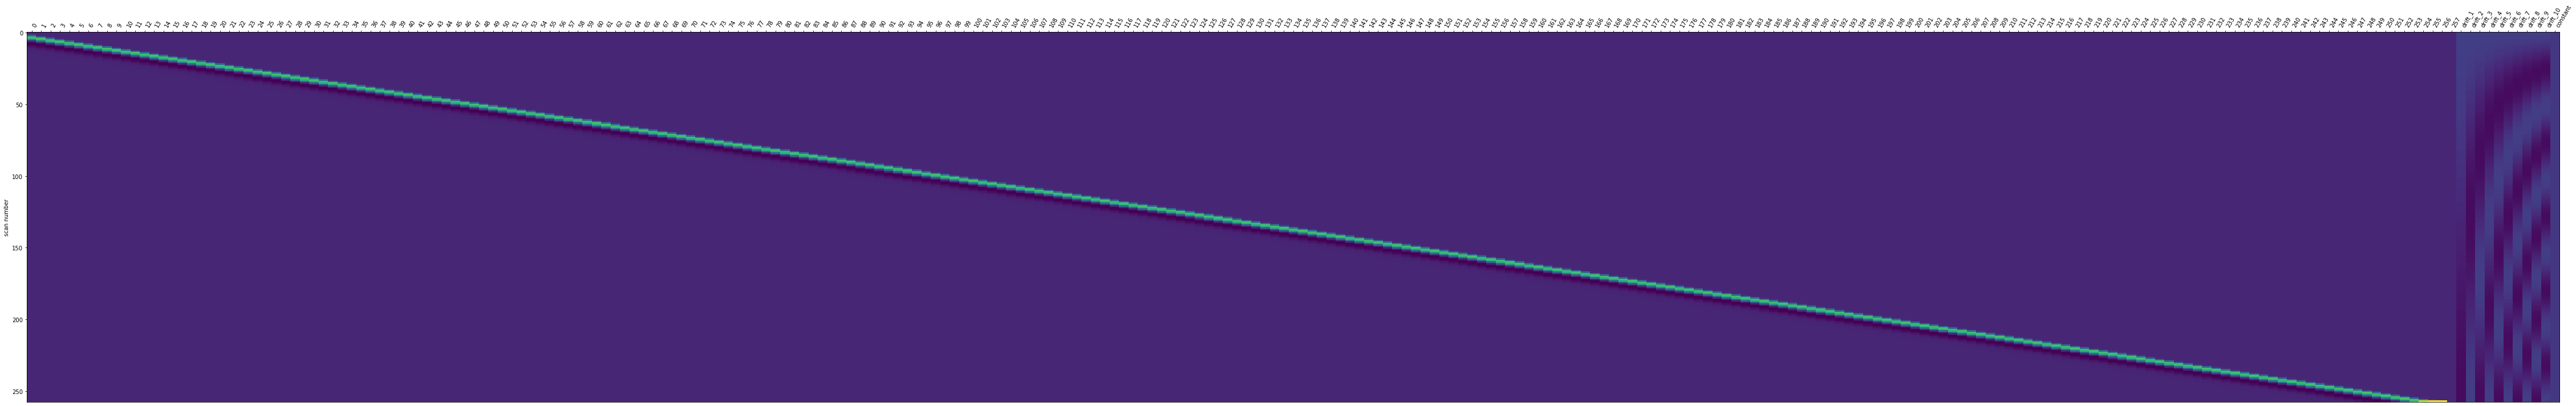

In [69]:
first_level_model = FirstLevelModel(tr)
first_level_model = first_level_model.fit(fmri_img, events=events_bs)
design_matrix_b_series = first_level_model.design_matrices_[0]
plot_design_matrix(design_matrix_b_series)

## Contrastes

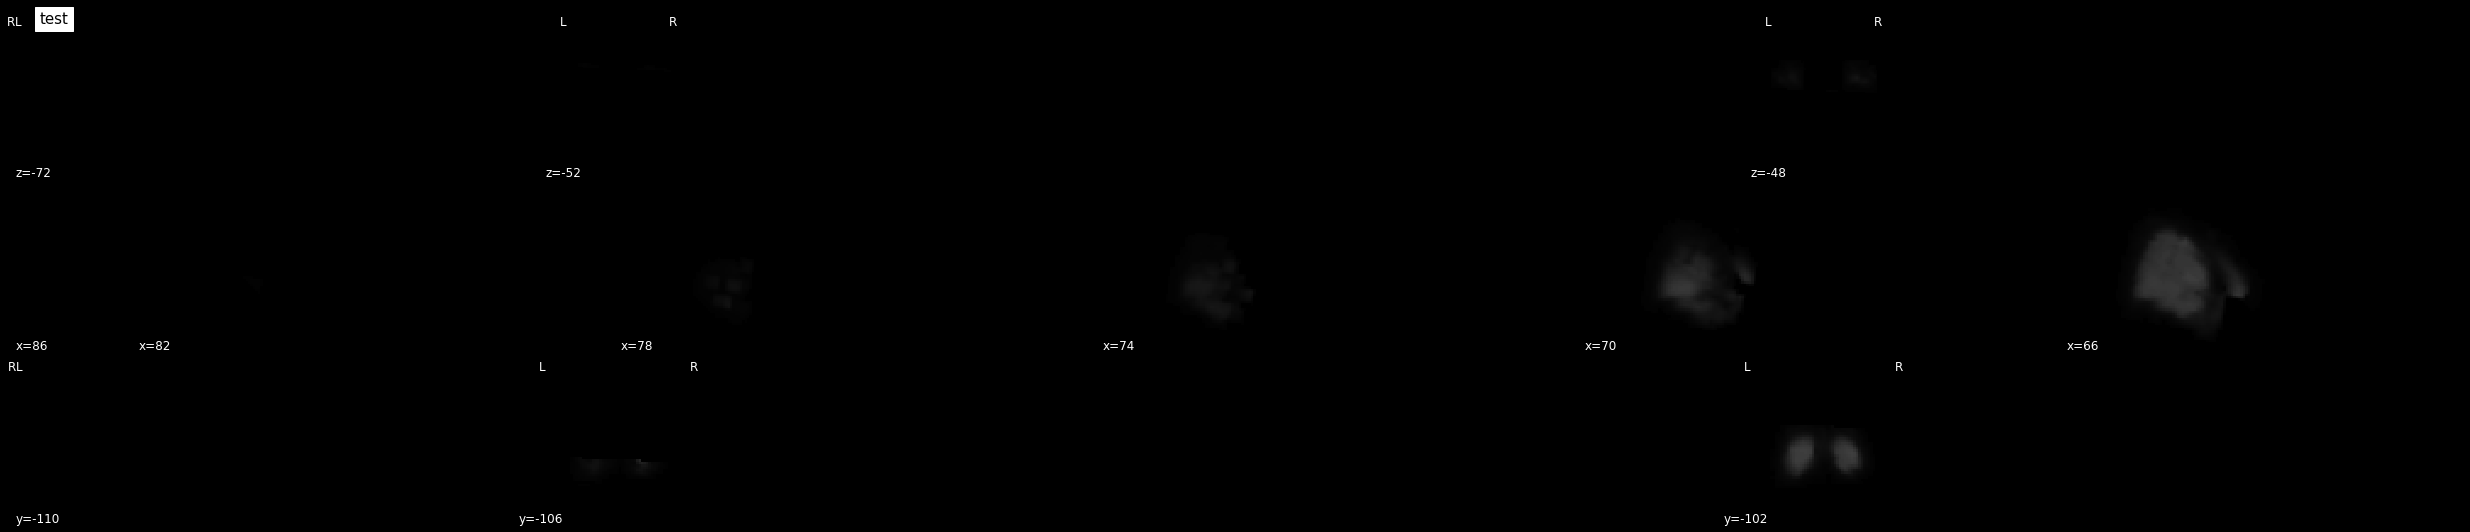

In [95]:
"""
# Esta parte será dedicada para fazer mascaras ao fazer o contraste entre baseline e vogais/silabas/palavras/frases
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

basic_contrasts['+Phrases-Baseline'] = (
    basic_contrasts['Phrases']
    - basic_contrasts['Baseline'])

basic_contrasts
"""



contrast_matrix_b_series = np.eye(design_matrix_b_series.shape[1])
basic_contrasts_b_series = dict([(column, contrast_matrix_b_series[i])
                        for i, column in enumerate(design_matrix_b_series.columns)])


basic_contrasts_new=[]
for idx in range(len(events_bs)):
    
    basic_contrasts_new.append(
        +basic_contrasts_b_series[idx]
        - 0)

fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix_b_series)

mean_image = mean_img(fmri_img)
z_map = fmri_glm.compute_contrast(basic_contrasts_new[0], output_type='z_score')

plotting.plot_stat_map(
    z_map, bg_img=mean_image, threshold=0, display_mode='mosaic', black_bg=True, title='test')
plotting.show()

## As linhas abaixo será para criação de máscaras

In [ ]:
from nilearn.input_data import NiftiMasker

masker = NiftiMasker()
z_map_mask= nilearn.image.threshold_img(z_map, threshold=3, copy=False)
masker.fit(z_map_mask)
z_map_mask=masker.mask_img_
plotting.plot_roi(z_map_mask, bg_img=mean_image,
                  cmap='Paired')

## Importação da brain_mask (caso se queira usar gm)

In [27]:
brain_mask = datasets.load_mni152_brain_mask()

from nilearn.datasets import fetch_icbm152_brain_gm_mask
brain_mask = fetch_icbm152_brain_gm_mask()

## Cross-validation

In [ ]:
from sklearn.model_selection import KFold
from nilearn.decoding import Decoder 

cv = KFold(n_splits=3)

fold = 0
for train, test in cv.split(labels):
    fold += 1
    decoder = Decoder(estimator='svc', mask=z_map_mask, standardize=True)
    decoder.fit(index_img(fmri_img, train), [labels[i] for i in train])
    prediction = decoder.predict(index_img(fmri_img, test))
    print(
        "CV Fold {:01d} | Prediction Accuracy: {:.3f}".format(
            fold,
            (prediction == [labels[i] for i in test]).sum() / float(len(
                test))))